# Importing necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Reading and Understading the data

In [2]:
f = 'complaints-2021-05-14_08_16.json'

with open(f, 'r') as file:
    data = json.load(file)
    
dataset=pd.json_normalize(data)

In [3]:
dataset.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


# Data Cleaning

In [4]:
dataset.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

Removing the following columns as they provide no real use for the problem:
 - `_index`
 - `_type`
 - `_id`
 - `_score`
 - `_source.tags`
 - `_source.complaint_id`
 - `_source.company_public_response`

Also removing `_source.company` since the dataset contains only a single unique value and hence is unnecessary and `_source.company_public_response` since the column has only 4 non-null values.

In [6]:
drop_list = ['_index', '_type', '_id', '_score', '_source.tags', '_source.complaint_id', '_source.company', '_source.company_public_response']
dataset = dataset.drop(columns=drop_list)

In [7]:
dataset.columns = dataset.columns.str.replace('_source.', '', regex=False)
dataset.columns

Index(['zip_code', 'issue', 'date_received', 'state', 'consumer_disputed',
       'product', 'company_response', 'submitted_via', 'date_sent_to_company',
       'sub_product', 'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided'],
      dtype='object')

In [8]:
dataset.replace(['', 'N/A'], pd.NA, inplace=True)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   zip_code                   71556 non-null  object
 1   issue                      78313 non-null  object
 2   date_received              78313 non-null  object
 3   state                      76322 non-null  object
 4   consumer_disputed          42630 non-null  object
 5   product                    78313 non-null  object
 6   company_response           78313 non-null  object
 7   submitted_via              78313 non-null  object
 8   date_sent_to_company       78313 non-null  object
 9   sub_product                67742 non-null  object
 10  timely                     78313 non-null  object
 11  complaint_what_happened    21072 non-null  object
 12  sub_issue                  32016 non-null  object
 13  consumer_consent_provided  34458 non-null  object
dtypes: obj

In [10]:
for column in dataset.columns:
    null_count = dataset[column].isnull().sum()
    percentage = (null_count/len(dataset))*100
    print(f"Column: '{column}': Null = {null_count},Total missing percentage = {percentage}")

Column: 'zip_code': Null = 6757,Total missing percentage = 8.62819710648296
Column: 'issue': Null = 0,Total missing percentage = 0.0
Column: 'date_received': Null = 0,Total missing percentage = 0.0
Column: 'state': Null = 1991,Total missing percentage = 2.542362059938963
Column: 'consumer_disputed': Null = 35683,Total missing percentage = 45.5645933625324
Column: 'product': Null = 0,Total missing percentage = 0.0
Column: 'company_response': Null = 0,Total missing percentage = 0.0
Column: 'submitted_via': Null = 0,Total missing percentage = 0.0
Column: 'date_sent_to_company': Null = 0,Total missing percentage = 0.0
Column: 'sub_product': Null = 10571,Total missing percentage = 13.498397456361014
Column: 'timely': Null = 0,Total missing percentage = 0.0
Column: 'complaint_what_happened': Null = 57241,Total missing percentage = 73.09258999144458
Column: 'sub_issue': Null = 46297,Total missing percentage = 59.11789868859576
Column: 'consumer_consent_provided': Null = 43855,Total missing pe

In [11]:
# Checking number of rows with more than 3 null values:
row_multiple_empty = dataset[dataset.isnull().sum(axis=1) > 3]
len(row_multiple_empty)

10827

In [12]:
dataset = dataset.dropna(thresh=dataset.shape[1] - 3)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67486 entries, 0 to 78312
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   zip_code                   62780 non-null  object
 1   issue                      67486 non-null  object
 2   date_received              67486 non-null  object
 3   state                      67378 non-null  object
 4   consumer_disputed          35446 non-null  object
 5   product                    67486 non-null  object
 6   company_response           67486 non-null  object
 7   submitted_via              67486 non-null  object
 8   date_sent_to_company       67486 non-null  object
 9   sub_product                63728 non-null  object
 10  timely                     67486 non-null  object
 11  complaint_what_happened    21032 non-null  object
 12  sub_issue                  30772 non-null  object
 13  consumer_consent_provided  34265 non-null  object
dtypes: object(1

In [13]:
for column in dataset.columns:
    null_count = dataset[column].isnull().sum()
    percentage = (null_count/len(dataset))*100
    print(f"Column: '{column}': Null = {null_count},Total missing percentage = {percentage}")

Column: 'zip_code': Null = 4706,Total missing percentage = 6.9732981655454465
Column: 'issue': Null = 0,Total missing percentage = 0.0
Column: 'date_received': Null = 0,Total missing percentage = 0.0
Column: 'state': Null = 108,Total missing percentage = 0.16003319206946626
Column: 'consumer_disputed': Null = 32040,Total missing percentage = 47.47651364727499
Column: 'product': Null = 0,Total missing percentage = 0.0
Column: 'company_response': Null = 0,Total missing percentage = 0.0
Column: 'submitted_via': Null = 0,Total missing percentage = 0.0
Column: 'date_sent_to_company': Null = 0,Total missing percentage = 0.0
Column: 'sub_product': Null = 3758,Total missing percentage = 5.568562368491243
Column: 'timely': Null = 0,Total missing percentage = 0.0
Column: 'complaint_what_happened': Null = 46454,Total missing percentage = 68.8350176332869
Column: 'sub_issue': Null = 36714,Total missing percentage = 54.402394570725775
Column: 'consumer_consent_provided': Null = 33221,Total missing 

As is evident, removing rows with more than 3 null values has greatly reduced the percentage of n null values for each column. Next removing rows that have null values in `zip_code`, `state` and `sub_product` columns.

In [14]:
dataset = dataset.dropna(subset=['zip_code', 'sub_product', 'state'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59544 entries, 0 to 78310
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   zip_code                   59544 non-null  object
 1   issue                      59544 non-null  object
 2   date_received              59544 non-null  object
 3   state                      59544 non-null  object
 4   consumer_disputed          30711 non-null  object
 5   product                    59544 non-null  object
 6   company_response           59544 non-null  object
 7   submitted_via              59544 non-null  object
 8   date_sent_to_company       59544 non-null  object
 9   sub_product                59544 non-null  object
 10  timely                     59544 non-null  object
 11  complaint_what_happened    14846 non-null  object
 12  sub_issue                  27793 non-null  object
 13  consumer_consent_provided  26408 non-null  object
dtypes: object(1

In [15]:
for column in dataset.columns:
    null_count = dataset[column].isnull().sum()
    percentage = (null_count/len(dataset))*100
    print(f"Column: '{column}': Null = {null_count},Total missing percentage = {percentage}")

Column: 'zip_code': Null = 0,Total missing percentage = 0.0
Column: 'issue': Null = 0,Total missing percentage = 0.0
Column: 'date_received': Null = 0,Total missing percentage = 0.0
Column: 'state': Null = 0,Total missing percentage = 0.0
Column: 'consumer_disputed': Null = 28833,Total missing percentage = 48.4230149133414
Column: 'product': Null = 0,Total missing percentage = 0.0
Column: 'company_response': Null = 0,Total missing percentage = 0.0
Column: 'submitted_via': Null = 0,Total missing percentage = 0.0
Column: 'date_sent_to_company': Null = 0,Total missing percentage = 0.0
Column: 'sub_product': Null = 0,Total missing percentage = 0.0
Column: 'timely': Null = 0,Total missing percentage = 0.0
Column: 'complaint_what_happened': Null = 44698,Total missing percentage = 75.06717721348919
Column: 'sub_issue': Null = 31751,Total missing percentage = 53.3235926373774
Column: 'consumer_consent_provided': Null = 33136,Total missing percentage = 55.64960365444042


Removing columns `consumer_disputed` and `consumer_consent_provided` since they have almost 50% null data.

In [16]:
dataset.drop(columns=['consumer_consent_provided', 'consumer_disputed'], inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59544 entries, 0 to 78310
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   zip_code                 59544 non-null  object
 1   issue                    59544 non-null  object
 2   date_received            59544 non-null  object
 3   state                    59544 non-null  object
 4   product                  59544 non-null  object
 5   company_response         59544 non-null  object
 6   submitted_via            59544 non-null  object
 7   date_sent_to_company     59544 non-null  object
 8   sub_product              59544 non-null  object
 9   timely                   59544 non-null  object
 10  complaint_what_happened  14846 non-null  object
 11  sub_issue                27793 non-null  object
dtypes: object(12)
memory usage: 5.9+ MB


In [17]:
for column in dataset.columns:
    null_count = dataset[column].isnull().sum()
    percentage = (null_count/len(dataset))*100
    print(f"Column: '{column}': Null = {null_count},Total missing percentage = {percentage}")

Column: 'zip_code': Null = 0,Total missing percentage = 0.0
Column: 'issue': Null = 0,Total missing percentage = 0.0
Column: 'date_received': Null = 0,Total missing percentage = 0.0
Column: 'state': Null = 0,Total missing percentage = 0.0
Column: 'product': Null = 0,Total missing percentage = 0.0
Column: 'company_response': Null = 0,Total missing percentage = 0.0
Column: 'submitted_via': Null = 0,Total missing percentage = 0.0
Column: 'date_sent_to_company': Null = 0,Total missing percentage = 0.0
Column: 'sub_product': Null = 0,Total missing percentage = 0.0
Column: 'timely': Null = 0,Total missing percentage = 0.0
Column: 'complaint_what_happened': Null = 44698,Total missing percentage = 75.06717721348919
Column: 'sub_issue': Null = 31751,Total missing percentage = 53.3235926373774


# Doubtful

In [18]:
dataset = dataset.dropna(subset=['sub_issue'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27793 entries, 0 to 78310
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   zip_code                 27793 non-null  object
 1   issue                    27793 non-null  object
 2   date_received            27793 non-null  object
 3   state                    27793 non-null  object
 4   product                  27793 non-null  object
 5   company_response         27793 non-null  object
 6   submitted_via            27793 non-null  object
 7   date_sent_to_company     27793 non-null  object
 8   sub_product              27793 non-null  object
 9   timely                   27793 non-null  object
 10  complaint_what_happened  10123 non-null  object
 11  sub_issue                27793 non-null  object
dtypes: object(12)
memory usage: 2.8+ MB


In [19]:
dataset.columns

Index(['zip_code', 'issue', 'date_received', 'state', 'product',
       'company_response', 'submitted_via', 'date_sent_to_company',
       'sub_product', 'timely', 'complaint_what_happened', 'sub_issue'],
      dtype='object')

In [20]:
for column in dataset.columns:
    null_count = dataset[column].isnull().sum()
    percentage = (null_count/len(dataset))*100
    print(f"Column: '{column}': Null = {null_count},Total missing percentage = {percentage}")

Column: 'zip_code': Null = 0,Total missing percentage = 0.0
Column: 'issue': Null = 0,Total missing percentage = 0.0
Column: 'date_received': Null = 0,Total missing percentage = 0.0
Column: 'state': Null = 0,Total missing percentage = 0.0
Column: 'product': Null = 0,Total missing percentage = 0.0
Column: 'company_response': Null = 0,Total missing percentage = 0.0
Column: 'submitted_via': Null = 0,Total missing percentage = 0.0
Column: 'date_sent_to_company': Null = 0,Total missing percentage = 0.0
Column: 'sub_product': Null = 0,Total missing percentage = 0.0
Column: 'timely': Null = 0,Total missing percentage = 0.0
Column: 'complaint_what_happened': Null = 17670,Total missing percentage = 63.57715971647537
Column: 'sub_issue': Null = 0,Total missing percentage = 0.0


In [21]:
dataset = dataset.dropna(subset=['complaint_what_happened'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10123 entries, 1 to 78310
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   zip_code                 10123 non-null  object
 1   issue                    10123 non-null  object
 2   date_received            10123 non-null  object
 3   state                    10123 non-null  object
 4   product                  10123 non-null  object
 5   company_response         10123 non-null  object
 6   submitted_via            10123 non-null  object
 7   date_sent_to_company     10123 non-null  object
 8   sub_product              10123 non-null  object
 9   timely                   10123 non-null  object
 10  complaint_what_happened  10123 non-null  object
 11  sub_issue                10123 non-null  object
dtypes: object(12)
memory usage: 1.0+ MB


In [34]:
for column in dataset.columns:
    print(f"{column}: Unique Count={len(dataset[column].unique())}")

zip_code: Unique Count=1301
issue: Unique Count=46
date_received: Unique Count=1659
state: Unique Count=56
product: Unique Count=6
company_response: Unique Count=3
submitted_via: Unique Count=1
date_sent_to_company: Unique Count=1666
sub_product: Unique Count=30
timely: Unique Count=2
complaint_what_happened: Unique Count=10032
sub_issue: Unique Count=171


Removing the column `submitted_via` since it has only one unique value.

In [35]:
dataset.drop(columns=['submitted_via'], inplace=True)

# Exploratory Data Analysis

## Univariate Analysis

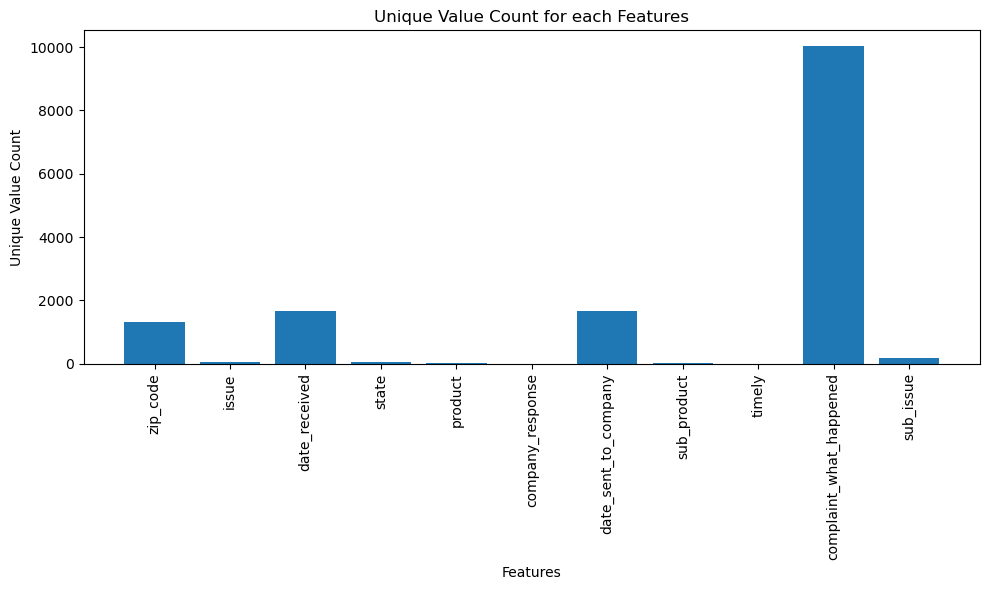

In [36]:
unique_count = [len(dataset[column].unique()) for column in dataset.columns]

plt.figure(figsize=(10,6))
plt.bar(dataset.columns, unique_count)
plt.xlabel('Features')
plt.ylabel('Unique Value Count')
plt.title('Unique Value Count for each Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

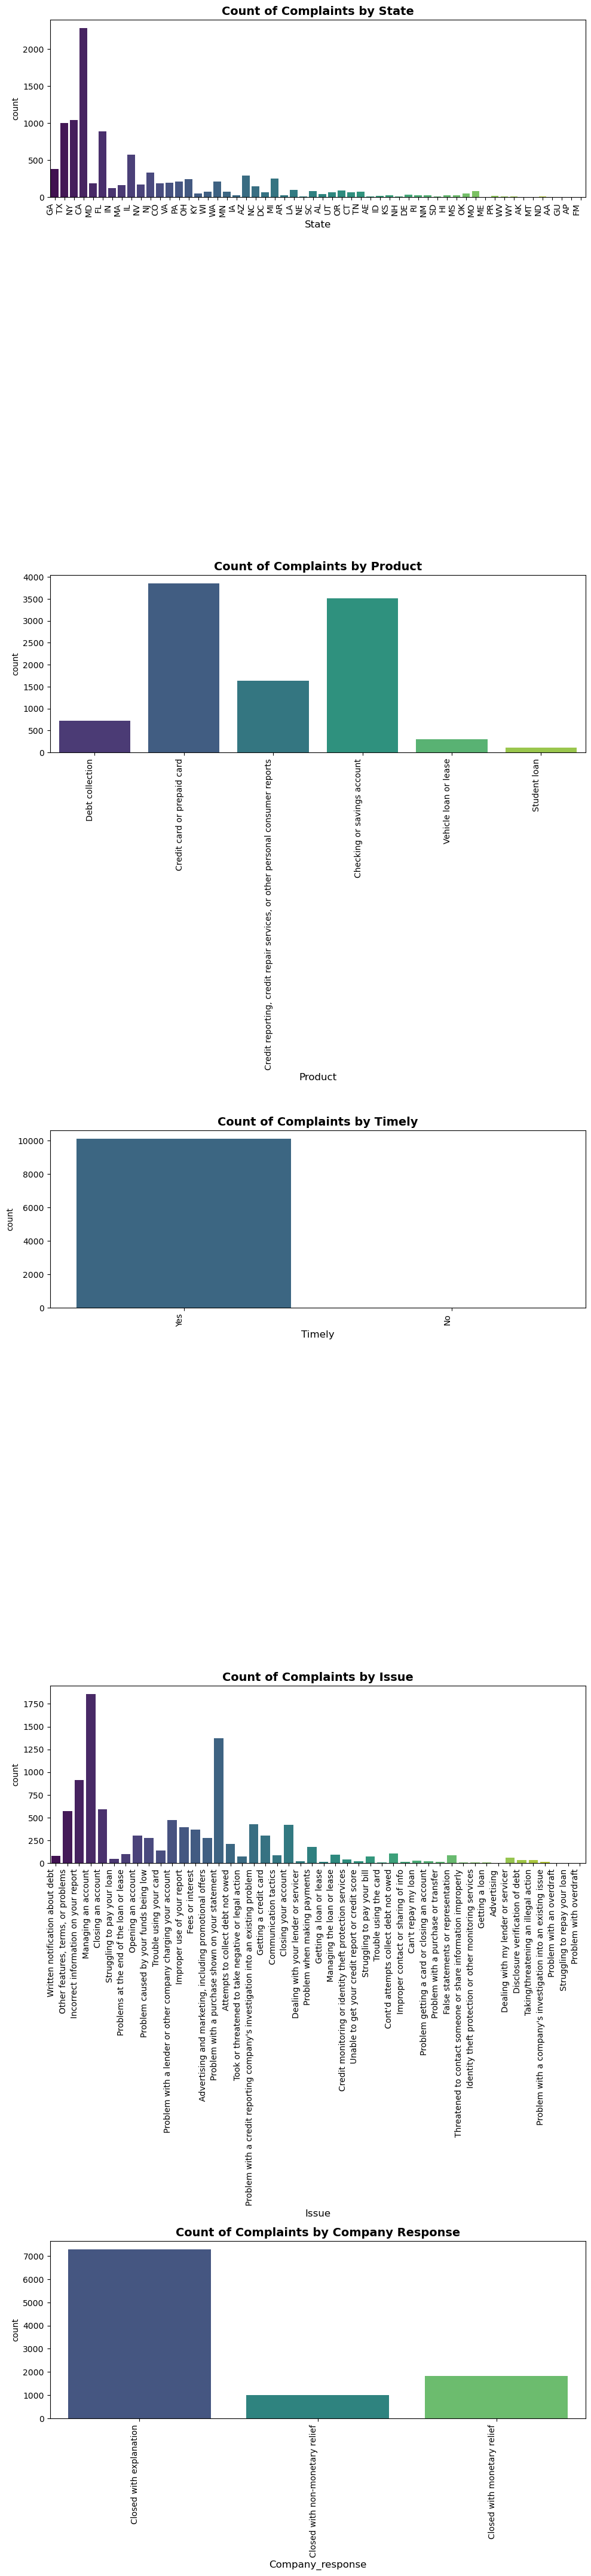

In [59]:
columns = ['state', 'product', 'timely', 'issue', 'company_response']
title = ['Count of Complaints by State', 'Count of Complaints by Product', 'Count of Complaints by Timely', 
         'Count of Complaints by Issue', 'Count of Complaints by Company Response']

plt.figure(figsize=(10, len(columns)*10))
for i, column in enumerate(columns):
    plt.subplot(6, 1, i+1)
    plt.title(title[i], fontsize=14, fontweight='bold')
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.xticks(rotation=90, fontsize=10, ha='right')
    sns.countplot(x=column, data=dataset, palette='viridis', hue=column, legend=False)

plt.tight_layout()
plt.show()